Declining  Fertility Rates
Collaborators: John Iglesias

In [248]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import json
import re
import seaborn as sns






pd.set_option("display.max_rows", 20000)


Introduction

The purpose of this project is to walk through a data science pipeline while 
exploring the world's fertility rate trends and its relationship with
global GDP (gross domestic output). Several countries around the globe have
experienced decreasing fertility rates for the past few decades which has
raised some ears

Data Processing

In [171]:
def getAllRegions():
    '''returns mapping of region to region id according to world bank'''
    url = f"http://api.worldbank.org/v2/country/"
    params = {
        "format": "json",
        "date": "1970:2020",
    }
    response = requests.get(url, params=params)
    response_json = response.json()
    regions = {}
    regionsRaw = response_json[1]
    
    for entry in regionsRaw:
        id = entry['region']['id']
        name = entry['region']['value']
        regions[name] = id
    del regions['Aggregates'] #remove aggregates
    return regions
allRegions = getAllRegions()
allRegions

{'Latin America & Caribbean ': 'LCN',
 'South Asia': 'SAS',
 'Sub-Saharan Africa ': 'SSF',
 'Europe & Central Asia': 'ECS',
 'Middle East & North Africa': 'MEA',
 'East Asia & Pacific': 'EAS',
 'North America': 'NAC'}

In [172]:
def parseRegionRow(rawStr):
    '''given an html string, parses string for year,
    and birth rate value, returns tuple'''
    # Extract date
    start = rawStr.find("<wb:date>") + len("<wb:date>")
    end = rawStr.find("</wb:date>", start)
    date = rawStr[start:end].strip()

    # Extract value
    value_pattern = r'<wb:value>(.*?)</wb:value>'
    match = re.search(value_pattern, rawStr)
    value = None
    if match:
        value = float(match.group(1))

    return(date, value)

In [173]:

def parseRegionData(regionID):
    '''retrieves raw string html data for region's birth rate data
    since 1970, returns list of tuples for each year and birth rate'''
    url = f'http://api.worldbank.org/v2/country/{regionID}/indicator/SP.DYN.CBRT.IN?per_page=10000&date=1970:2022'

    # Send an HTTP GET request to the API endpoint
    response = requests.get(url)

    # Extract data from the response
    dataRaw = response.content.decode('utf-8').split('\n')

    #data is in html string format
    rawRegionData = ', '.join(dataRaw)
    rawRegionData = rawRegionData.split("<wb:data>\r,")

    output = []
    for s in rawRegionData:
        output.append(parseRegionRow(s))
    output = output[1:]
    return output




In [174]:

def getRegionBirthRateDF():
    '''returns df for birth rates for each world region from 1970-2022'''
    allDFs = [] #contains each df for each region
    for region in allRegions:
        data = parseRegionData(allRegions[region])
        regionDF = pd.DataFrame([(tup[0], tup[1]) for tup in data], columns=['year', 'birth_rate'])
        #add country column
        regionDF.insert(0, 'region', region)
        allDFs.append(regionDF)
    #combine all dfs
    allDFs = pd.concat(allDFs, ignore_index=True)
    return allDFs

regionBirthRateDF = getRegionBirthRateDF()
regionBirthRateDF.head(10)


,region,year,birth_rate
0,Latin America & Caribbean,2021,NaN
1,Latin America & Caribbean,2020,15.099382
2,Latin America & Caribbean,2019,15.504359
3,Latin America & Caribbean,2018,15.996603
4,Latin America & Caribbean,2017,16.306751
5,Latin America & Caribbean,2016,16.550194
6,Latin America & Caribbean,2015,17.054733
7,Latin America & Caribbean,2014,17.331161
8,Latin America & Caribbean,2013,17.559314
9,Latin America & Caribbean,2012,17.846142


In [195]:
def getCountryBirthRateDF() -> pd.DataFrame:
    ''''returns df of every country's birth rate annually since 1970'''
    # Get a list of all country codes
    url = "http://api.worldbank.org/v2/country/all?per_page=500&format=json"
    response = requests.get(url)
    country_codes = [c['id'] for c in response.json()[1]]

    # Retrieve birth rate data for each country
    data = []
    for country_code in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/SP.DYN.CBRT.IN"
        params = {
            "format": "json",
            "date": "1970:2020",
        }
        response = requests.get(url, params=params)
        response_json = response.json()
        # Check if the response is valid before iterating over it
        if len(response_json) > 1:
            if response_json[1]:
                for entry in response_json[1]:
                    data.append({
                        "country": entry["country"]["value"],
                        "date": entry["date"],
                        "birth_rate": entry["value"],
                    })

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [196]:
birthCountryDF = getCountryBirthRateDF()


In [197]:
birthCountryDF.head(10)

,country,date,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [198]:
allCountries = set()
for country in pycountry.countries:
    allCountries.add(country.name.lower())
    
def isCountry(place):
    '''returns true if place is a country, false ow'''
    return place.lower() in allCountries
       

In [199]:
#remove rows that're not countries
birthCountryDF = birthCountryDF[birthCountryDF['country'].apply(lambda x: isCountry(str(x)))]

#rename date column
birthCountryDF = birthCountryDF.rename(columns={'date': 'year'})

birthCountryDF.head(10)

,country,year,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [200]:
def get_gdp_df():
    '''returns df of every country's gdp annually since 1970'''
    url = 'https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?per_page=20000&date=1970:2022&format=json'
    response = requests.get(url)

    # Extract JSON data from response
    data = response.json()
    df = pd.json_normalize(data[1])

    # get relevant columns
    df = df[['country.value', 'date', 'value']]
    
    # Rename columns
    df.columns = ['country', 'year', 'gdp']


    return df

gdpCountryDF = get_gdp_df()
gdpCountryDF.head(10)








,country,year,gdp
0,Africa Eastern and Southern,2022,NaN
1,Africa Eastern and Southern,2021,1.089454e+12
2,Africa Eastern and Southern,2020,9.341791e+11
3,Africa Eastern and Southern,2019,1.009052e+12
4,Africa Eastern and Southern,2018,1.016697e+12
5,Africa Eastern and Southern,2017,1.030482e+12
6,Africa Eastern and Southern,2016,8.898593e+11
7,Africa Eastern and Southern,2015,9.231439e+11
8,Africa Eastern and Southern,2014,1.003403e+12
9,Africa Eastern and Southern,2013,9.826771e+11


In [201]:
#remove countrues so regions remain
gdpRegionDF = gdpCountryDF[gdpCountryDF['country'].apply(lambda x: not isCountry(str(x)))]
gdpRegionDF = gdpRegionDF.rename(columns={'country': 'region'})



#remove rows that're not countries
gdpCountryDF = gdpCountryDF[gdpCountryDF['country'].apply(lambda x: isCountry(str(x)))]





In [168]:
'''check all regions'''
gdpRegionDF['country'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

In [226]:
'''left join regionBirthRateDf with regionGDP df'''

#convert year columns to int
regionBirthRateDF['year'] = regionBirthRateDF['year'].astype(int)
gdpRegionDF['year'] = gdpRegionDF['year'].astype(int)

#remove whitespace from region values
gdpRegionDF = gdpRegionDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
regionBirthRateDF = regionBirthRateDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

regionDF = regionBirthRateDF.merge(gdpRegionDF, on=['region', 'year'], how='left')
regionDF.head(10)

,region,year,birth_rate,gdp
0,Latin America & Caribbean,2021,NaN,5.454429e+12
1,Latin America & Caribbean,2020,15.099382,4.742372e+12
2,Latin America & Caribbean,2019,15.504359,5.618711e+12
3,Latin America & Caribbean,2018,15.996603,5.702983e+12
4,Latin America & Caribbean,2017,16.306751,5.831864e+12
5,Latin America & Caribbean,2016,16.550194,5.249605e+12
6,Latin America & Caribbean,2015,17.054733,5.372086e+12
7,Latin America & Caribbean,2014,17.331161,6.428177e+12
8,Latin America & Caribbean,2013,17.559314,6.303809e+12
9,Latin America & Caribbean,2012,17.846142,6.152225e+12


In [232]:
'''left join gdp and birth rate tables by gdp for countries'''

#remove whitespace from region values
gdpCountryDF = gdpCountryDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
birthCountryDF = birthCountryDF.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

countryDF = gdpCountryDF.merge(birthCountryDF, on=['country', 'year'], how='left')
countryDF.head(10)



,country,year,gdp,birth_rate
0,Afghanistan,2022,NaN,NaN
1,Afghanistan,2021,1.478686e+10,NaN
2,Afghanistan,2020,2.014344e+10,36.051
3,Afghanistan,2019,1.890449e+10,36.466
4,Afghanistan,2018,1.841885e+10,36.927
5,Afghanistan,2017,1.889635e+10,37.342
6,Afghanistan,2016,1.801956e+10,37.936
7,Afghanistan,2015,1.999816e+10,38.803
8,Afghanistan,2014,2.055058e+10,39.105
9,Afghanistan,2013,2.056449e+10,39.601


Exploratory data analysis

    Plot each country's GDP since 1970

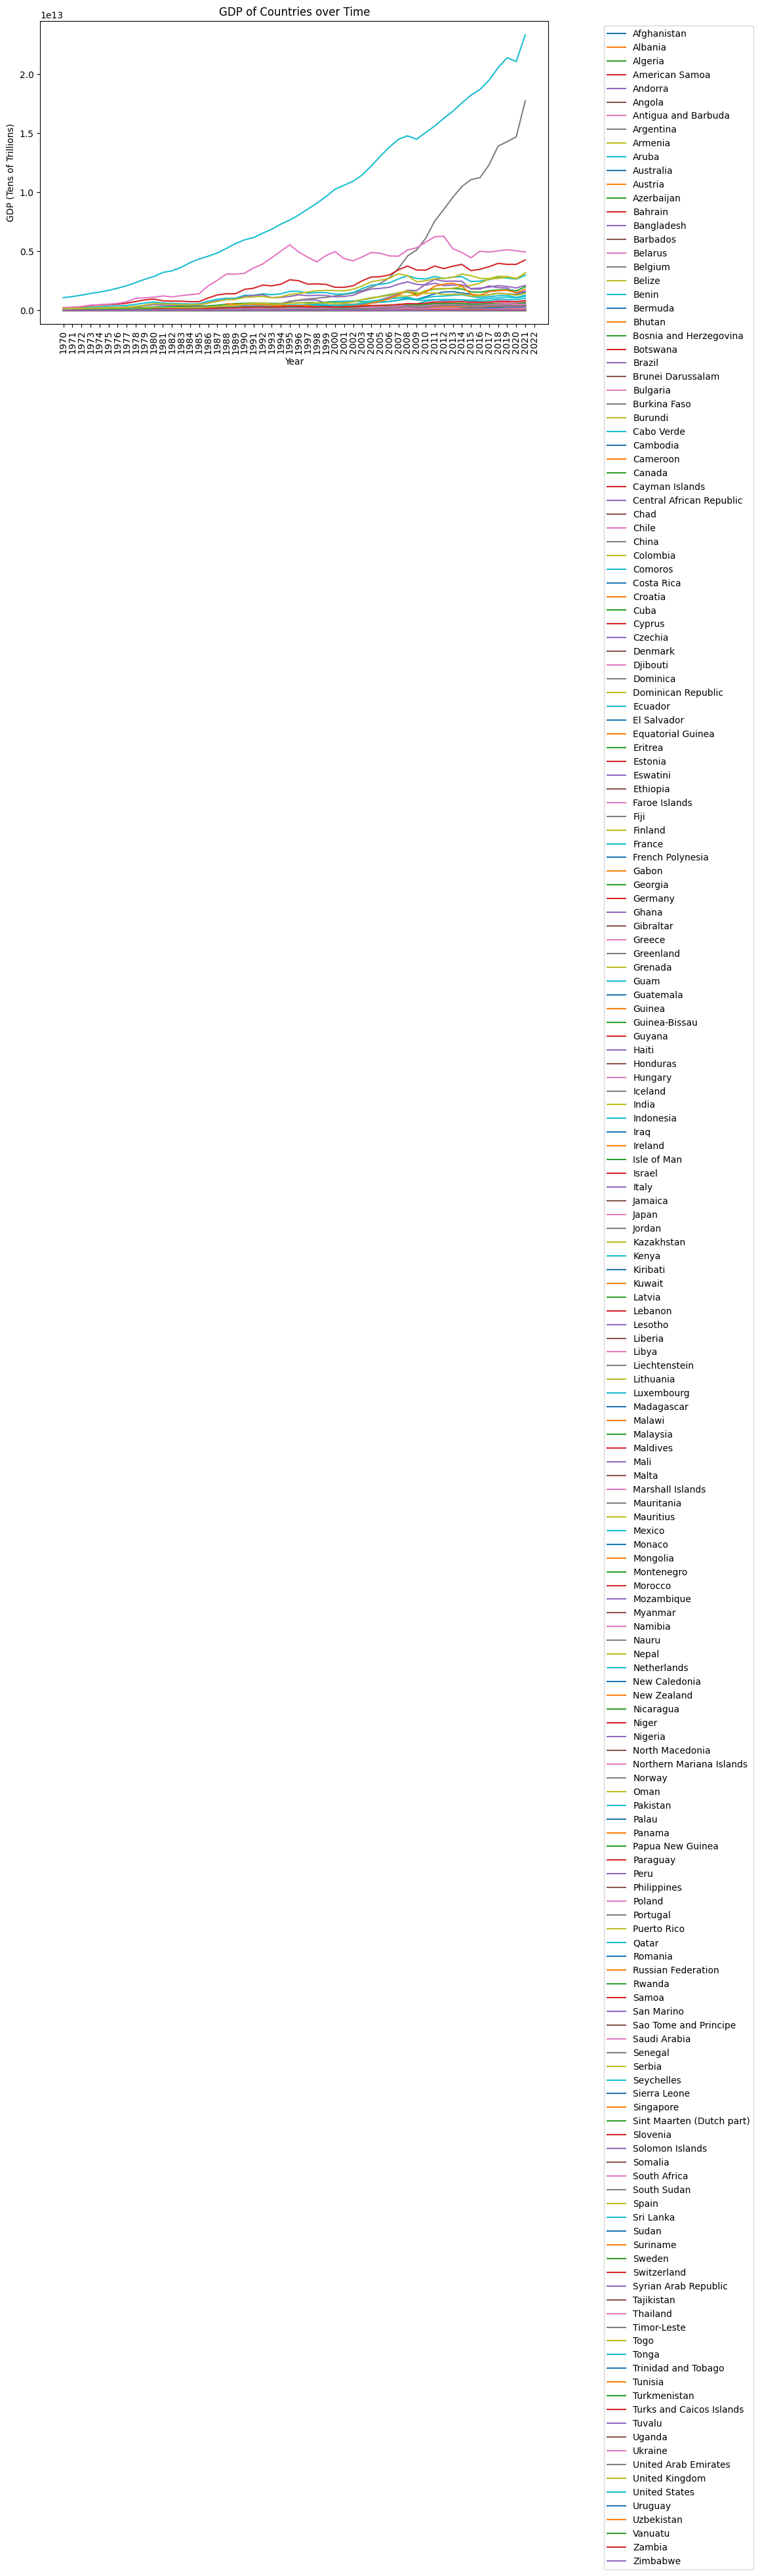

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in countryDF.country.unique():
    sub_df = countryDF[countryDF.country == country]
    ax.plot(sub_df.year, sub_df.gdp, label=country)

ax.set_xlabel('Year')
ax.set_ylabel('GDP (Tens of Trillions)')
ax.set_title('GDP of Countries over Time')
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
# rotate the x-ticks by 45 degrees
plt.xticks(rotation=90)
# flip the x-axis
ax.invert_xaxis()

plt.show()








As you can see, the US and China are huge GDP outliers since 1970, with the rest
 of the world's GDP staying relatively stagnant under 5  trillion dollars.

Lets instead plot a scatter plot marking the GDPs for each year

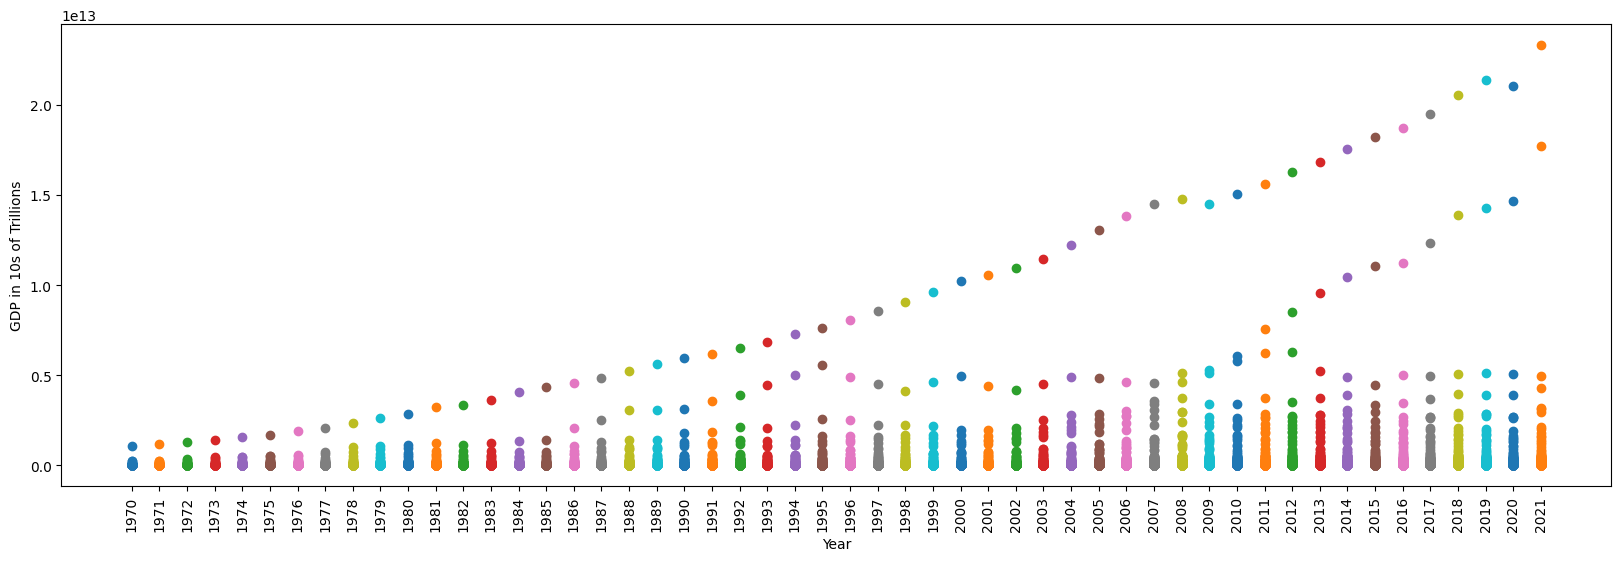

In [258]:
import matplotlib.pyplot as plt

# group the data by year
grouped = countryDF.groupby('year')

# create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# loop through each group and plot as scatter plot
for name, group in grouped:
    ax.scatter(group['year'], group['gdp'], label=name)

# set the x-axis label and rotate the tick labels
ax.set_xlabel('Year')
plt.xticks(rotation=90)

# set the y-axis label
ax.set_ylabel('GDP in 10s of Trillions')



# show the plot
plt.show()




Now lets visualize the birth rates for every country.

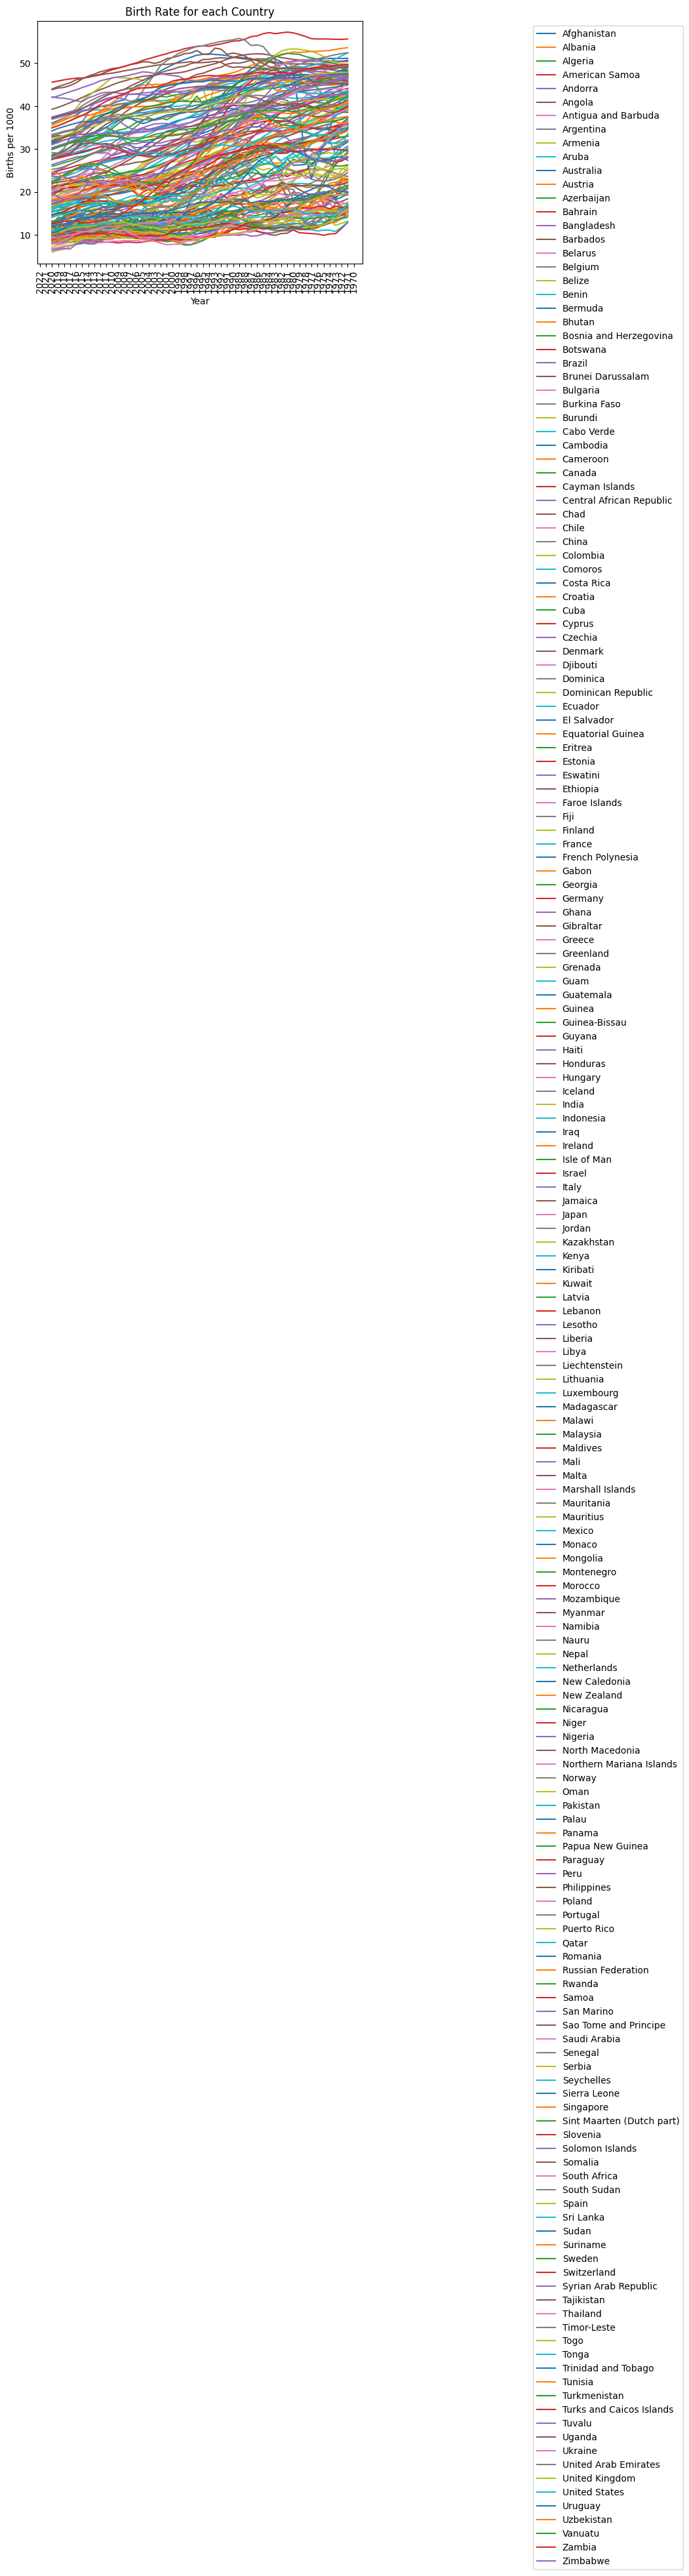

<Figure size 2000x600 with 0 Axes>

In [243]:
# Group the data by country
grouped = countryDF.groupby('country')

# Loop through each country group and plot the birth rate over the years
for name, group in grouped:
    plt.plot(group['year'], group['birth_rate'], label=name)

# Add labels and legend to the plot
plt.xlabel('Year')
plt.ylabel('Births per 1000')
plt.title('Birth Rate for each Country')

# adjust the right margin to make room for the legend
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))
# rotate the x-ticks by 45 degrees
plt.xticks(rotation=90)

plt.figure(figsize=(20, 6))


# Show the plot
plt.show()






